# Drake Passage Transport

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

In [2]:
db='/g/data/x77/amh157/x77/PanAnt/panant.db'
session=cc.database.create_session(db)

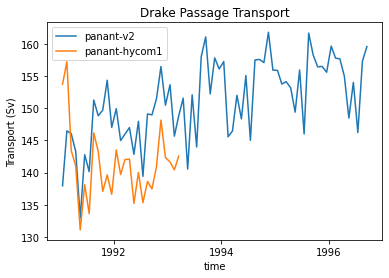

In [3]:
expts = ['panant-v2','panant-hycom1']
for expt in expts:
    umo_2d = cc.querying.getvar(expt,'umo_2d', session)
    DP = umo_2d.sel(xq=-71,method='nearest').sum('yh')/1e9
    DP.plot(label=expt)
    
plt.title('Drake Passage Transport')
plt.ylabel('Transport (Sv)')
plt.legend()

# Barotropic streamfunction over the last year

In [4]:
depth = cc.querying.getvar('panant-v2','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

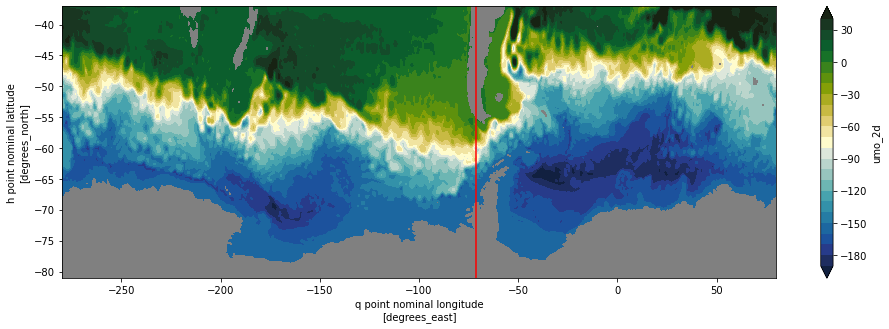

In [5]:
umo_2d = cc.querying.getvar('panant-v2','umo_2d', session)
psi = umo_2d.isel(time=slice(-12,-1)).mean('time').cumsum('yh')/1e9
psi = (psi - psi.sel(xq=-71,method='nearest').sel(yh=-40,method='nearest')).load()
plt.figure(figsize=(16,5))
psi.plot.contourf(levels=np.arange(-190,50,10),cmap=cm.cm.delta)
plt.contourf(depth.xh,depth.yh,land_mask,colors='grey')
plt.axvline(-71,color='r')
plt.title('panant-v2')

Text(0.5, 1.0, 'panant-hycom1')

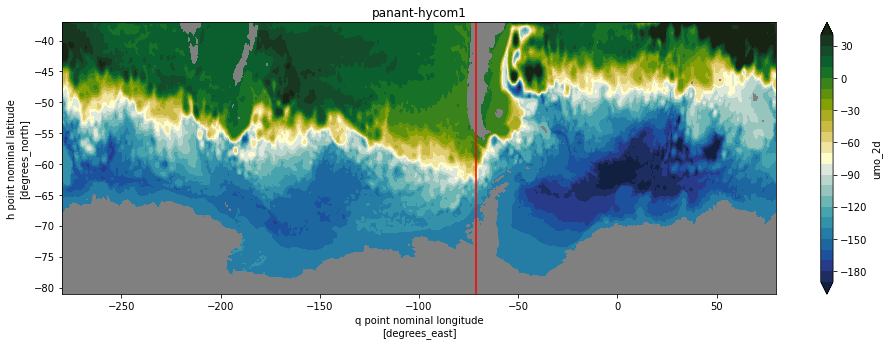

In [6]:
umo_2d = cc.querying.getvar('panant-hycom1','umo_2d', session)
psi = umo_2d.isel(time=slice(-12,-1)).mean('time').cumsum('yh')/1e9
psi = (psi - psi.sel(xq=-71,method='nearest').sel(yh=-40,method='nearest')).load()
plt.figure(figsize=(16,5))
psi.plot.contourf(levels=np.arange(-190,50,10),cmap=cm.cm.delta)
plt.contourf(depth.xh,depth.yh,land_mask,colors='grey')
plt.axvline(-71,color='r')
plt.title('panant-hycom1')